In [120]:
import pandas as pd
import numpy as np
from rep.utils import train_test_split_group
from numpy import genfromtxt, mean, std
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import KFold
import xgboost as xgb

In [121]:
train = pd.read_csv("data/training.csv")
test = pd.read_csv("data/test.csv")
subm = pd.read_csv("data/submission.csv")

In [122]:
train.columns

Index(['EventID', 'Label', 'Mass', 'Corrected_mass', 'Pt', 'Pt_sum', 'Pt_min',
       'IP_chi2', 'IP_chi2_sum', 'Flight_distance', 'Pseudorapidity',
       'Track_number_PV', 'Tracks_number', 'Tracks_number_passed',
       'Vertex_chi2', 'Weight'],
      dtype='object')

In [15]:
len(train[(train['Pseudorapidity'])>1])

498412

In [123]:
train['size'] = train.groupby(['EventID'])['Mass'].transform('count') 
test['size'] = test.groupby(['EventID'])['Mass'].transform('count') 

In [124]:
lab1 = train[train['Label']==1]
lab0 = train[train["Label"]==0]

In [133]:
def f(x):
    if x>60000:
        return 0
    else:
        return 1

In [134]:
lab1['met'] = lab1.Flight_distance.apply(f)

/home/dz/.local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [135]:
lab1['met'].unique()

array([1, 0])

In [19]:
import matplotlib.pyplot as plt

In [54]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib

Using matplotlib backend: Qt4Agg


In [86]:

lab0[lab0['Flight_distance']<300000]['Flight_distance'].hist(bins=150,normed=True,color= 'red')
lab1[lab1['Flight_distance']<300000]['Flight_distance'].hist(bins=150,normed=True)
plt.show()

In [83]:
lab1[lab1['Flight_distance']>(60000)]['Label'] = 3

5334

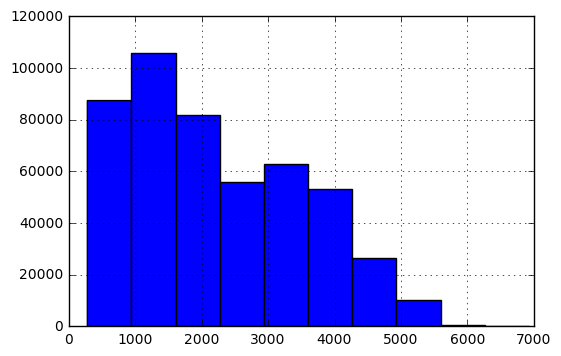

In [30]:
lab1['Mass'].hist()
plt.show()

In [ ]:
mass:4.5-5.5

In [28]:
plt.figure();
lab1.diff().hist(color='k', alpha=0.5, bins=100,figsize=(100, 100));
plt.show()

In [3]:
trainmean=train.groupby('EventID', as_index=False).mean()
testmean=test.groupby('EventID', as_index=False).mean()

In [4]:
trainmin=train.groupby('EventID', as_index=False).min()
trainmax=train.groupby('EventID', as_index=False).max()
trainsum=train.groupby('EventID', as_index=False).sum()

testmin=test.groupby('EventID', as_index=False).min()
testmax=test.groupby('EventID', as_index=False).max()
testsum=test.groupby('EventID', as_index=False).sum()

In [5]:
trainmin=trainmin.drop(['EventID','Label','Weight'],axis=1)
trainmax=trainmax.drop(['EventID','Label','Weight'],axis=1)
trainsum=trainsum.drop(['EventID','Label','Weight'],axis=1)

testmin=testmin.drop('EventID',axis=1)
testmax=testmax.drop('EventID',axis=1)
testsum=testsum.drop('EventID',axis=1)

trainmin.columns=[trainmin.columns + 'min']
trainmax.columns=[trainmax.columns + 'max']
trainsum.columns=[trainsum.columns + 'sum']

testmin.columns=[testmin.columns + 'min']
testmax.columns=[testmax.columns + 'max']
testsum.columns=[testsum.columns + 'sum']

In [6]:
trainfirst=train.groupby('EventID', as_index=False).first()
trainlast=train.groupby('EventID', as_index=False).last()
trainmedian=train.groupby('EventID', as_index=False).median()

testfirst=test.groupby('EventID', as_index=False).first()
testlast=test.groupby('EventID', as_index=False).last()
testmedian=test.groupby('EventID', as_index=False).median()

In [7]:
trainfirst=trainfirst.drop(['EventID','Label','Weight'],axis=1)
trainlast=trainlast.drop(['EventID','Label','Weight'],axis=1)
trainmedian=trainmedian.drop(['EventID','Label','Weight'],axis=1)

testfirst=testfirst.drop('EventID',axis=1)
testlast=testlast.drop('EventID',axis=1)
testmedian=testmedian.drop('EventID',axis=1)

trainfirst.columns=[trainfirst.columns + 'first']
trainlast.columns=[trainlast.columns + 'last']
trainmedian.columns=[trainmedian.columns + 'median']

testfirst.columns=[testfirst.columns + 'first']
testlast.columns=[testlast.columns + 'last']
testmedian.columns=[testmedian.columns + 'median']

In [8]:
trainadd=pd.concat([trainmin,trainmax],axis=1)
testadd=pd.concat([testmin,testmax],axis=1)

#trainadd=pd.concat([trainmin,trainmax,trainfirst[list({'IP_chi2first','Flight_distancefirst'})],trainlast[list({'IP_chi2last','Flight_distancelast'})]],axis=1)
#testadd=pd.concat([testmin,testmax,testfirst[list({'IP_chi2first','Flight_distancefirst'})],testlast[list({'IP_chi2last','Flight_distancelast'})]],axis=1)

In [9]:
trainsize=train.groupby('EventID', as_index=False).size()
testsize=test.groupby('EventID', as_index=False).size()

In [10]:
train=trainmean
test=testmean

In [11]:
train['Size']=trainsize
test['Size']=testsize

#train['IPmin']=trainmin.IP_chi2
#train['IPmax']=trainmax.IP_chi2max
#train['Massmin']=trainmin.Corrected_mass
train['Dissum']=trainsum.Pseudorapiditysum
train['Rapidsum']=trainsum.Flight_distancesum
#train['Deltamass']=trainmax.Corrected_mass-trainmin.Corrected_mass

#test['IPmin']=testmin.IP_chi2
#test['IPmax']=testmax.IP_chi2max
#test['Massmin']=testmin.Corrected_mass
test['Dissum']=testsum.Pseudorapiditysum
test['Rapidsum']=testsum.Flight_distancesum
#test['Deltamass']=testmax.Corrected_mass-testmin.Corrected_mass

train.shape

(81068, 19)

In [12]:
train=pd.concat([train,trainadd],axis=1)
test=pd.concat([test,testadd],axis=1)

In [13]:
params = {
'max_depth': 7,
'eta': 0.015,
'nthread': 4,
'subsample': 0.8,
'eval_metric': ['auc'],
'objective': 'binary:logistic',
'colsample_bytree': 0.9,
'min_child_weight': 0,
'scale_pos_weight':(1-train.Label.mean())/train.Label.mean(),
'seed':7
}

In [14]:
#train['Proba']=0
#test['Proba']=0
features0 = list(set(test.columns) - {'EventID', 'Label', 'Weight'})

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=0)
>>> sss.get_n_splits(X, y)
3
>>> print(sss)       
StratifiedShuffleSplit(n_splits=3, random_state=0, ...)
>>> for train_index, test_index in sss.split(X, y):
...    print("TRAIN:", train_index, "TEST:", test_index)
...    X_train, X_test = X[train_index], X[test_index]
...    y_train, y_test = y[train_index], y[test_index]

In [35]:
from sklearn.model_selection import StratifiedKFold

X = np.ones(10)
y = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
     print("%s %s" % (train, test))

ImportError: No module named 'sklearn.model_selection'

In [40]:
training_data0, validation_data0 = train_test_split_group(train.EventID, train, random_state=2, train_size=0.5)
training_data0.head()

,EventID,Label,Mass,Corrected_mass,Pt,Pt_sum,Pt_min,IP_chi2,IP_chi2_sum,Flight_distance,...,Pt_summax,Pt_minmax,IP_chi2max,IP_chi2_summax,Flight_distancemax,Pseudorapiditymax,Track_number_PVmax,Tracks_numbermax,Tracks_number_passedmax,Vertex_chi2max
3,3,1,2394.412399,5485.029999,3338.225999,4002.941999,727.396399,74.398391,271.691799,285.186199,...,4721.389991,1404.369978,203.060011,302.052991,350.687015,3.657001,0,3,2,0.463277
5,5,1,1206.118510,2162.280010,2162.010010,2425.935010,436.817010,18.078030,168.555010,189.826010,...,2659.180006,437.605015,28.788715,174.447006,196.450006,4.143656,1,3,1,0.801079
6,6,1,2777.138504,4688.979170,5040.451670,5372.345004,643.559170,60.915604,321.683420,383.727504,...,7090.610015,1065.950012,221.544022,441.872004,565.332004,3.550142,0,4,2,4.041312
12,12,1,2997.543007,4884.500007,4881.955007,5784.312507,1731.732507,567.937020,3207.215007,4896.912507,...,7707.440005,2117.930000,1901.730020,4280.420005,7052.190005,2.864060,0,3,3,1.896973
15,15,1,2281.517507,4409.187507,2264.350007,3114.745007,341.652507,192.590557,1464.105757,1504.558757,...,3595.160002,471.989011,277.379005,2159.350005,2160.810005,4.807602,0,3,1,9.229581


In [15]:
from sklearn.metrics import roc_auc_score
def compute_mean(event_ids, values):
    """ fore each event computes average of given values """
    number_of_sv_in_event = np.bincount(event_ids)
    return np.bincount(event_ids, weights=values) / number_of_sv_in_event

In [18]:
test.shape

(84000, 43)

In [19]:
dtest = xgb.DMatrix(test[features0])
prob=0
au=0
for i in range(20):
    training_data0, validation_data0 = train_test_split_group(train.EventID, train, random_state=i, train_size=0.5)
    print(training_data0.shape,validation_data0.shape)
    dtr = xgb.DMatrix(training_data0[features0], label=training_data0.Label)
    dval = xgb.DMatrix(validation_data0[features0], label=validation_data0.Label)
    watchlist = [(dtr, 'train'), (dval, 'eval')]
    history = dict()
    model0 = xgb.train(params, dtr, num_boost_round=1000, evals=watchlist,evals_result=history, verbose_eval=50)
    proba = model0.predict(dval)
    events_ids = np.unique(validation_data0.EventID)

    # compute number of SVs in each event
    number_of_sv_in_event = np.bincount(validation_data0.EventID)

    # compute predictions for events (take the mean value of predictions for SVs forming an event)
    events_proba = compute_mean(validation_data0.EventID, proba)[events_ids]

    # compute weights for events 
    events_weights = compute_mean(validation_data0.EventID, validation_data0.Weight)[events_ids]

    # compute labels for events 
    events_labels = compute_mean(validation_data0.EventID, validation_data0.Label)[events_ids]
    a=roc_auc_score(events_labels, events_proba, sample_weight=events_weights)
    au=au+a
    print(a)
    print(au*(1/(i+1)))
    prob = prob + model0.predict(dtest)

(40534, 45) (40534, 45)
[0]	train-auc:0.95538	eval-auc:0.943464
[50]	train-auc:0.978976	eval-auc:0.965321
[100]	train-auc:0.984315	eval-auc:0.969627
[150]	train-auc:0.987644	eval-auc:0.972816
[200]	train-auc:0.99002	eval-auc:0.974965
[250]	train-auc:0.991619	eval-auc:0.976206
[300]	train-auc:0.992909	eval-auc:0.977084
[350]	train-auc:0.993884	eval-auc:0.977717
[400]	train-auc:0.99473	eval-auc:0.978206
[450]	train-auc:0.995468	eval-auc:0.978561
[500]	train-auc:0.996145	eval-auc:0.978882
[550]	train-auc:0.996654	eval-auc:0.979105
[600]	train-auc:0.997102	eval-auc:0.979253
[650]	train-auc:0.997503	eval-auc:0.9794
[700]	train-auc:0.997854	eval-auc:0.979513
[750]	train-auc:0.998133	eval-auc:0.979619
[800]	train-auc:0.998375	eval-auc:0.979714
[850]	train-auc:0.998585	eval-auc:0.979793
[900]	train-auc:0.998759	eval-auc:0.979835
[950]	train-auc:0.998914	eval-auc:0.979882
0.974840257661
0.974840257661
(40534, 45) (40534, 45)
[0]	train-auc:0.955154	eval-auc:0.944325
[50]	train-auc:0.979819	eval-

In [20]:
prob

array([  0.15798593,  19.96386528,  18.36011887, ...,  19.99640656,
        19.98108864,  19.99764442], dtype=float32)

In [43]:
dtest = xgb.DMatrix(test[features0])

proba=0
kf = KFold(train.shape[0], n_folds=20,shuffle=True)
for train_index, val_index in kf:
    print("TRAIN:", train_index, "TEST:", val_index)
    training_data0, validation_data0 = train.loc[train_index], train.loc[val_index]
    print(training_data0.shape,validation_data0.shape)
    dtr = xgb.DMatrix(training_data0[features0], label=training_data0.Label)
    dval = xgb.DMatrix(validation_data0[features0], label=validation_data0.Label)
    watchlist = [(dtr, 'train'), (dval, 'eval')]
    history = dict()
    model0 = xgb.train(params, dtr, num_boost_round=1000, evals=watchlist,evals_result=history, verbose_eval=10)

    proba = proba+model0.predict(dtest)

TRAIN: [    0     1     2 ..., 81065 81066 81067] TEST: [   53    69    71 ..., 80996 81014 81055]
(77014, 45) (4054, 45)
[0]	train-auc:0.959566	eval-auc:0.956998


KeyboardInterrupt: 

# НЕ КОМПИЛЬ

In [261]:
weight=train.Weight
train['Weight']=(train['Weight']*100).astype(int)

In [281]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['Weight'] = le.fit_transform(train.Weight)

In [285]:
gbm = xgb.XGBClassifier()
features1 = list(set(test.columns) - {'EventID', 'Label', 'Weight'})
dtrain = xgb.DMatrix(train[features1], label=train.Weight)

In [290]:
params = {
    'objective': 'multi:softmax',
    'num_class': 7,
    'max_depth': 8,
    'eta': 0.1
}
trees = 150

In [292]:
from sklearn.metrics import log_loss
cv = xgb.train(params, dtrain, show_progress=True, nfold=5, show_stdv=False, num_boost_round=trees)

TypeError: train() got an unexpected keyword argument 'show_progress'

# КОМПИЛЬ

In [117]:
features = list(set(train.columns) - {'EventID', 'Label', 'Weight'})#'EventID',
print(features)
training_data, validation_data = train_test_split_group(train.EventID, train, random_state=7, train_size=0.8)
training_data.shape,validation_data.shape

['Vertex_chi2', 'Pt_summax', 'Vertex_chi2min', 'Dissum', 'Flight_distance', 'Tracks_numbermin', 'IP_chi2max', 'IP_chi2min', 'Pt_sum', 'Rapidsum', 'Pt_summin', 'Track_number_PVmin', 'Massmax', 'Ptmin', 'Pt_minmin', 'Ptmax', 'Tracks_number', 'Tracks_number_passedmin', 'Pt', 'Track_number_PV', 'IP_chi2_summax', 'Vertex_chi2max', 'Tracks_number_passedmax', 'Pseudorapidity', 'Mass', 'Pseudorapiditymax', 'Track_number_PVmax', 'Massmin', 'Flight_distancemax', 'Tracks_numbermax', 'IP_chi2_summin', 'Corrected_massmax', 'Corrected_massmin', 'IP_chi2_sum', 'Pseudorapiditymin', 'IP_chi2', 'Size', 'Pt_min', 'Flight_distancemin', 'Corrected_mass', 'Tracks_number_passed', 'Pt_minmax']


((64854, 45), (16214, 45))

# BIG DIM SIZE

In [91]:

import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

In [102]:
n_estimator = 1000
X_train, X_test, y_train, y_test = training_data,validation_data,training_data.Label, validation_data.Label
# It is important to train the ensemble of trees on a different subset
training, validation = train_test_split_group(training_data.EventID, training_data, random_state=7, train_size=0.8)
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = training[features],validation[features],training.Label, validation.Label

In [103]:
X_train, X_test, y_train, y_test = training_data[features],validation_data[features],training_data.Label, validation_data.Label

In [95]:
X_train.columns

Index(['Vertex_chi2', 'Pt_summax', 'Vertex_chi2min', 'Dissum',
       'Flight_distance', 'Tracks_numbermin', 'IP_chi2max', 'IP_chi2min',
       'Pt_sum', 'Rapidsum', 'Pt_summin', 'Track_number_PVmin', 'Massmax',
       'Ptmin', 'Pt_minmin', 'Ptmax', 'Tracks_number',
       'Tracks_number_passedmin', 'Pt', 'Track_number_PV', 'IP_chi2_summax',
       'Vertex_chi2max', 'Tracks_number_passedmax', 'Pseudorapidity', 'Mass',
       'Pseudorapiditymax', 'Track_number_PVmax', 'Massmin',
       'Flight_distancemax', 'Tracks_numbermax', 'IP_chi2_summin',
       'Corrected_massmax', 'Corrected_massmin', 'IP_chi2_sum',
       'Pseudorapiditymin', 'IP_chi2', 'Size', 'Pt_min', 'Flight_distancemin',
       'Corrected_mass', 'Tracks_number_passed', 'Pt_minmax'],
      dtype='object')

In [104]:
rt = RandomTreesEmbedding(max_depth=10, n_estimators=n_estimator,
    random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

In [97]:
y_pred_rt

array([ 0.49317514,  0.9989016 ,  0.99914706, ...,  0.99511008,
        0.99865086,  0.9819425 ])

In [105]:
proba = y_pred_rt
events_ids = np.unique(validation_data.EventID)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba = compute_mean(validation_data.EventID, proba)[events_ids]

# compute weights for events 
events_weights = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]
roc_auc_score(events_labels, events_proba, sample_weight=events_weights)

0.95492227923140416

In [106]:
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=10, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

In [107]:
proba = y_pred_rf_lm 
events_ids = np.unique(validation_data.EventID)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba = compute_mean(validation_data.EventID, proba)[events_ids]

# compute weights for events 
events_weights = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]
roc_auc_score(events_labels, events_proba, sample_weight=events_weights)

0.95347687442264617

In [108]:
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)


# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)


In [109]:
proba = y_pred_grd
events_ids = np.unique(validation_data.EventID)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba = compute_mean(validation_data.EventID, proba)[events_ids]

# compute weights for events 
events_weights = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]
roc_auc_score(events_labels, events_proba, sample_weight=events_weights)

0.97155040866301456

In [112]:
rf = xgb.XGBClassifier(max_depth= 6,learning_rate= 0.015,nthread=4,subsample= 0.8,objective='binary:logistic',colsample_bytree= 0.9,min_child_weight=0,
                       n_estimators=1000,seed=1337,scale_pos_weight=(1-y_train.mean())/y_train.mean())
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

In [113]:
proba = y_pred_rf_lm
events_ids = np.unique(validation_data.EventID)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba = compute_mean(validation_data.EventID, proba)[events_ids]

# compute weights for events 
events_weights = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]
roc_auc_score(events_labels, events_proba, sample_weight=events_weights)

0.97003544170836797

In [73]:
# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)


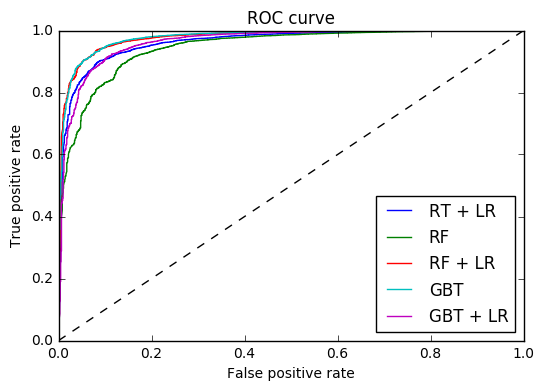

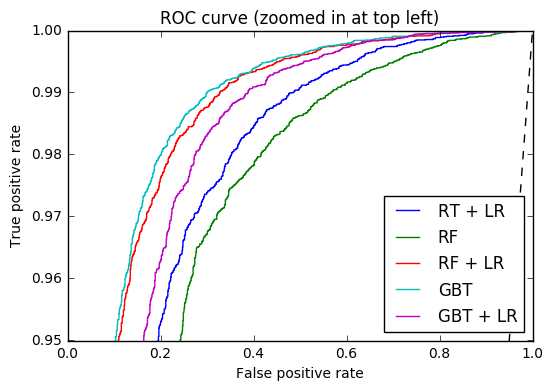

In [114]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 1)
plt.ylim(0.95, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# NN

In [118]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

Using Theano backend.


In [121]:
from sklearn import metrics
from keras import backend as K

def auc(y_true, y_pred):
    return metrics.roc_auc_score(K.eval(y_true), K.eval(y_pred))

In [145]:
nn = Sequential()
nn.add(Dense(128, input_dim=training_data[features].shape[1], init='uniform'))
nn.add(Activation('relu'))
nn.add(Dense(1, init='uniform'))
nn.add(Activation('softmax'))

opt = Adam(lr=1e-3)
nn.compile(loss='binary_crossentropy', optimizer=opt)

In [146]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [147]:
hist = nn.fit(ss.fit_transform(training_data[features]), training_data.Label, validation_data=(ss.transform(validation_data[features]), validation_data.Label))

Train on 64854 samples, validate on 16214 samples
Epoch 1/10
64854/64854 [==============================] - 3s - loss: 1.0772 - val_loss: 1.1209
Epoch 2/10
64854/64854 [==============================] - 3s - loss: 1.0772 - val_loss: 1.1209
Epoch 3/10
64854/64854 [==============================] - 3s - loss: 1.0772 - val_loss: 1.1209
Epoch 4/10
64854/64854 [==============================] - 3s - loss: 1.0772 - val_loss: 1.1209
Epoch 5/10
64854/64854 [==============================] - 3s - loss: 1.0772 - val_loss: 1.1209
Epoch 6/10
64854/64854 [==============================] - 3s - loss: 1.0772 - val_loss: 1.1209
Epoch 7/10
64854/64854 [==============================] - 3s - loss: 1.0772 - val_loss: 1.1209
Epoch 8/10
64854/64854 [==============================] - 3s - loss: 1.0772 - val_loss: 1.1209
Epoch 9/10
64854/64854 [==============================] - 3s - loss: 1.0772 - val_loss: 1.1209
Epoch 10/10
64854/64854 [==============================] - 3s - loss: 1.0772 - val_loss: 1.1209

In [167]:
proba = clf3_p
events_ids = np.unique(validation_data.EventID)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba = compute_mean(validation_data.EventID, proba)[events_ids]

# compute weights for events 
events_weights = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]
roc_auc_score(events_labels, events_proba, sample_weight=events_weights)

ValueError: object too deep for desired array

In [148]:
clf3_p = nn.predict(ss.transform(validation_data[features]))

In [151]:
len(clf3_p),sum(clf3_p)

(16214, array([ 16214.], dtype=float32))

In [ ]:
to_categorical(yval)

In [128]:

import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [131]:
encoder = LabelEncoder()
encoder.fit(training_data.Label)
encoded_Y = encoder.transform(training_data.Label)

In [132]:
encoded_Y

array([1, 0, 1, ..., 1, 1, 1])

In [156]:

def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(50, input_dim=training_data[features].shape[1], init='normal', activation='relu'))
	model.add(Dense(1, init='normal', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [157]:
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(encoded_Y, n_folds=5, shuffle=True, random_state=7)
results = cross_val_score(estimator, training_data[features], encoded_Y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

IndexError: indices are out-of-bounds

In [185]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(30, input_dim=training_data[features].shape[1], init='uniform', activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
          optimizer='adam', metrics=['accuracy'])#rmsprop
model.fit(np.matrix(training_data[features]), training_data.Label, nb_epoch=5, batch_size=10)

Epoch 1/5
64854/64854 [==============================] - 5s - loss: 1.0774 - acc: 0.9324     
Epoch 2/5
64854/64854 [==============================] - 6s - loss: 1.0774 - acc: 0.9324     
Epoch 3/5
64854/64854 [==============================] - 5s - loss: 1.0774 - acc: 0.9324     
Epoch 4/5
64854/64854 [==============================] - 5s - loss: 1.0774 - acc: 0.9324     
Epoch 5/5
64854/64854 [==============================] - 6s - loss: 1.0774 - acc: 0.9324     


In [186]:
clf3_p = model.predict(ss.transform(validation_data[features]))

In [187]:
model.metrics_names

['loss', 'acc']

In [192]:
proba = p
events_ids = np.unique(validation_data.EventID)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba = proba

# compute weights for events 
events_weights = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]
roc_auc_score(events_labels, events_proba, sample_weight=events_weights)

ValueError: bad input shape (16214, 2)

In [169]:
validation_data.shape

(16214, 45)

# LR

In [ ]:
from sklearn.linear_model import LogisticRegression

In [190]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(training_data[features], training_data.Label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [191]:
p=lr.predict_proba(validation_data[features])

In [199]:
proba =  p
events_ids = np.unique(validation_data.EventID)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba = compute_mean(validation_data.EventID, proba[:, 1])[events_ids]

# compute weights for events 
events_weights = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]

In [200]:
roc_auc_score(events_labels, events_proba, sample_weight=events_weights)

0.97178285621901961

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

In [197]:
calib = CalibratedClassifierCV(RandomForestClassifier(n_jobs=4, n_estimators=1000), cv=3, method='isotonic')
calib.fit(training_data[features], training_data.Label)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv=3, method='isotonic')

In [198]:
p=calib.predict_proba(validation_data[features])

In [ ]:
proba = model.predict_proba(validation_data[features])
events_ids = np.unique(validation_data.EventID)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba = compute_mean(validation_data.EventID, proba[:, 1])[events_ids]

# compute weights for events 
events_weights = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]

In [86]:
dtr = xgb.DMatrix(training_data[features], label=training_data.Label)
dval = xgb.DMatrix(validation_data[features], label=validation_data.Label)
watchlist = [(dtr, 'train'), (dval, 'eval')]
history = dict()
model = xgb.train(params, dtr, num_boost_round=1000, evals=watchlist,evals_result=history, verbose_eval=10)

[0]	train-auc:0.958396	eval-auc:0.945933
[10]	train-auc:0.971211	eval-auc:0.959141
[20]	train-auc:0.973656	eval-auc:0.961164
[30]	train-auc:0.974654	eval-auc:0.962398
[40]	train-auc:0.975671	eval-auc:0.96401
[50]	train-auc:0.976927	eval-auc:0.965236
[60]	train-auc:0.978149	eval-auc:0.966146
[70]	train-auc:0.979339	eval-auc:0.967049
[80]	train-auc:0.980307	eval-auc:0.967833
[90]	train-auc:0.981228	eval-auc:0.968508
[100]	train-auc:0.98214	eval-auc:0.969268
[110]	train-auc:0.983006	eval-auc:0.970085
[120]	train-auc:0.983739	eval-auc:0.970823
[130]	train-auc:0.984359	eval-auc:0.971448
[140]	train-auc:0.98503	eval-auc:0.972108
[150]	train-auc:0.985589	eval-auc:0.972625
[160]	train-auc:0.986132	eval-auc:0.973063
[170]	train-auc:0.98667	eval-auc:0.973551
[180]	train-auc:0.987135	eval-auc:0.97396
[190]	train-auc:0.98757	eval-auc:0.974312
[200]	train-auc:0.987958	eval-auc:0.974656
[210]	train-auc:0.988323	eval-auc:0.974942
[220]	train-auc:0.988663	eval-auc:0.975244
[230]	train-auc:0.989023	eva

In [21]:
from sklearn.metrics import roc_auc_score
def compute_mean(event_ids, values):
    """ fore each event computes average of given values """
    number_of_sv_in_event = np.bincount(event_ids)
    return np.bincount(event_ids, weights=values) / number_of_sv_in_event

In [88]:
training_data, validation_data = train_test_split_group(train.EventID, train, random_state=7, train_size=0.8)
training_data.shape,validation_data.shape

# predict each SV
proba = model.predict(dval)
events_ids = np.unique(validation_data.EventID)

# compute number of SVs in each event
number_of_sv_in_event = np.bincount(validation_data.EventID)

# compute predictions for events (take the mean value of predictions for SVs forming an event)
events_proba = compute_mean(validation_data.EventID, proba)[events_ids]

# compute weights for events 
events_weights = compute_mean(validation_data.EventID, validation_data.Weight)[events_ids]

# compute labels for events 
events_labels = compute_mean(validation_data.EventID, validation_data.Label)[events_ids]

In [89]:
from sklearn.metrics import roc_auc_score
roc_auc_score(events_labels, events_proba, sample_weight=events_weights)

0.97419607706288536

In [203]:
kaggle_proba = calib.predict_proba(test[features])
kaggle_proba

array([[  9.19537998e-01,   8.04620018e-02],
       [  2.44696670e-03,   9.97553033e-01],
       [  3.04793938e-02,   9.69520606e-01],
       ..., 
       [  2.87055809e-04,   9.99712944e-01],
       [  2.87055809e-04,   9.99712944e-01],
       [  2.87055809e-04,   9.99712944e-01]])

In [19]:
proba

array([  0.09719893,  19.95125961,  17.15072823, ...,  19.9961319 ,
        19.97328186,  19.99761391], dtype=float32)

In [21]:
kaggle_proba = prob

kaggle_ids = np.unique(test.EventID)
# compute predictions for events (take the mean value of predictions for SVs forming an event)
kaggle_events_proba = compute_mean(test.EventID, kaggle_proba)[kaggle_ids]

In [204]:
kaggle_proba = prob

kaggle_ids = np.unique(test.EventID)
# compute predictions for events (take the mean value of predictions for SVs forming an event)
kaggle_events_proba = compute_mean(test.EventID, kaggle_proba[:, 1])[kaggle_ids]

In [22]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='xgb1and2005fold.csv'):
    """saves predictions to file and provides a link for downloading """
    pd.DataFrame({'EventID': ids, 'Label': proba}).to_csv('{}'.format(filename), index=False)
    return FileLink('{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_events_proba)

/home/dz/kaggle/kvantCollaider/xgb1and2005fold.csv

In [112]:
test1 = pd.read_csv("xgbmean700full.csv")
test2 = pd.read_csv("meanbayes+xgbmean+inna.csv")
test3 = pd.read_csv("bayesnotmean.csv")
test4 = pd.read_csv("mean.csv")
test5 = pd.read_csv('xgb1and20kfold.csv')

In [115]:
test4.Label= test2.Label*(1/3)+test5.Label*(1/20)#+test3.Label

In [116]:
test4.head()

,EventID,Label
0,0,0.009876
1,1,1.839937
2,2,1.689566
3,3,1.668448
4,4,0.018557


In [118]:
test2.head()

,EventID,Label
0,0,0.015047
1,1,2.527121
2,2,2.496088
3,3,2.455083
4,4,0.026771


In [92]:
test5.head()

,EventID,Label
0,0,0.005412
1,1,0.995548
2,2,0.875956
3,3,0.905887
4,4,0.008825


In [10]:
test4.head()

,EventID,Label
0,0,0.011972
1,1,2.174349
2,2,2.215306
3,3,2.131769
4,4,0.022685


In [9]:
test4['Label'] = test1.Label*(1/20)+test2.Label*(1/3)+test3.Label

In [119]:
test4.to_csv('meanbest+20fold.csv', index=False)

In [ ]:
lab0 = trainmedian[train.Label == 0]
lab1 = trainmedian[train.Label == 1]

col = trainmedian.columns
print(col)
for c in col:
    z_statistic, p_value = stats.wilcoxon(lab0[c] - lab1[c])
    print(c,lab0[c].max(),lab1[c].max(),p_value)

In [ ]:
import matplotlib.pyplot as plt
fig, ax =plt.subplots(figsize=(9,9))
ax.matshow(train.corr(),vmin=-1,vmax=1)
plt.yticks(range(train.shape[1]),train.columns)
plt.xticks(range(train.shape[1]),train.columns,rotation=45,ha='left')
plt.show()

In [ ]:
a=train[train['Label']==1]
a[a['Size']==1].count()

In [147]:
train[train['Label']==0].Weight.unique()

array([ 1.])